### CASE 1 Visualize the Experiment Result

In [1]:
from cornac.experiment.experiment_explainers import Experiment_Explainers
from cornac.datasets.goodreads import prepare_data
from cornac.datasets import goodreads
from cornac.metrics_explainer import (
    Metric_Exp_DIV as DIV,
    Metric_Exp_FPR as FPR,
    Metric_Exp_FA as FA,
    Metric_Exp_RA as RA,
)
from cornac.models import EFM, MTER
from cornac.models import ALS, MF, EMF, NEMF

from cornac.explainer import Exp_EFM, Exp_MTER
from cornac.explainer import (
    Exp_ALS as ALSExplainer,
    Exp_PHI4MF as PHI4MFExplainer,
    Exp_SU4EMF as EMFExplainer,
)

from cornac.experiment import Visualization
from cornac.utils import cache
import warnings

warnings.filterwarnings("ignore")

/Users/yaoyao/miniconda3/envs/rose/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/yaoyao/miniconda3/envs/rose/lib/python3.9/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
rs_sent_dense = prepare_data(
    data_name="goodreads",
    test_size=0,
    dense=True,
    item=True,
    user=True,
    sample_size=1,
    seed=21,
)
fdiv = DIV()
fpr = FPR()
ground_truth_good_reads = goodreads.load_sentiment()
fpr_with_input_as_groundtruth = FPR(ground_truth=ground_truth_good_reads)
efm = EFM(
    max_iter=20,
    num_explicit_factors=50,
    num_latent_factors=50,
    num_most_cared_aspects=50,
    alpha=0.85,
    lambda_h=0.1,
    lambda_u=0.001,
    lambda_v=0.01,
    lambda_x=1.0,
    lambda_y=0.1,
)
efm_exp = Exp_EFM(rec_model=efm, dataset=rs_sent_dense.train_set)
mter = MTER(
    max_iter=20,
    n_aspect_factors=8,
    n_item_factors=5,
    n_opinion_factors=5,
    n_user_factors=10,
    lambda_bpr=10,
    lambda_reg=10,
    n_bpr_samples=1000,
    n_element_samples=50,
)
mter_exp = Exp_MTER(rec_model=mter, dataset=rs_sent_dense.train_set)

rs_dense = prepare_data(
    data_name="goodreads_uir_1000",
    test_size=0,
    dense=True,
    item=True,
    user=True,
    sample_size=1,
    seed=21,
)
emf = EMF(
    k=10,
    max_iter=500,
    learning_rate=0.001,
    lambda_reg=0.1,
    explain_reg=0.01,
    verbose=True,
    seed=6,
    num_threads=6,
    early_stop=True,
)
nemf = NEMF(
    k=10,
    max_iter=500,
    learning_rate=0.001,
    lambda_reg=0.1,
    explain_reg=0.01,
    novel_reg=1,
    verbose=True,
    seed=6,
    num_threads=6,
    early_stop=True,
)
als = ALS(k=10, max_iter=500, lambda_reg=0.001, alpha=1, verbose=True, seed=6)
als_exp = ALSExplainer(rec_model=als, dataset=rs_dense.train_set)
emf_exp = EMFExplainer(rec_model=emf, dataset=rs_dense.train_set)
nemf_exp = EMFExplainer(rec_model=nemf, dataset=rs_dense.train_set)

# models = [(als, als_exp), (emf, emf_exp), (nemf, nemf_exp)]
models = [(als, als_exp)]
metrics = [fdiv]
experiment = Experiment_Explainers(
    eval_method=rs_dense,
    models=models,
    metrics=metrics,
    rec_k=10,
    feature_k=10,
    eval_train=True,
)
experiment.run()

models = [(efm, efm_exp), (mter, mter_exp)]
metrics = [fdiv, fpr_with_input_as_groundtruth]
experiment_sent = Experiment_Explainers(
    eval_method=rs_sent_dense,
    models=models,
    metrics=metrics,
    rec_k=10,
    feature_k=10,
    eval_train=True,
)
experiment_sent.run()

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...
100%|██████████| 500/500 [00:01<00:00, 417.70it/s, loss=0.0285]
INFO:implicit:Final training loss 0.0285
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 1000/1000 [00:02<00:00, 335.76it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.15033573573555856
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.15033573573555856, 1.234774112701416, 3.8778128623962402]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |      Metric_Exp_DIV | 

Plot the bar chart for the metrics:


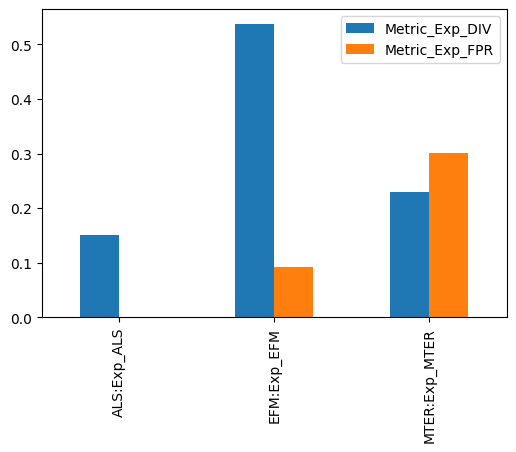

               Metric_Exp_DIV  Metric_Exp_FPR
ALS:Exp_ALS          0.150336        0.000000
EFM:Exp_EFM          0.537337        0.092513
MTER:Exp_MTER        0.229126        0.301079
Plot the bar chart for the cost:


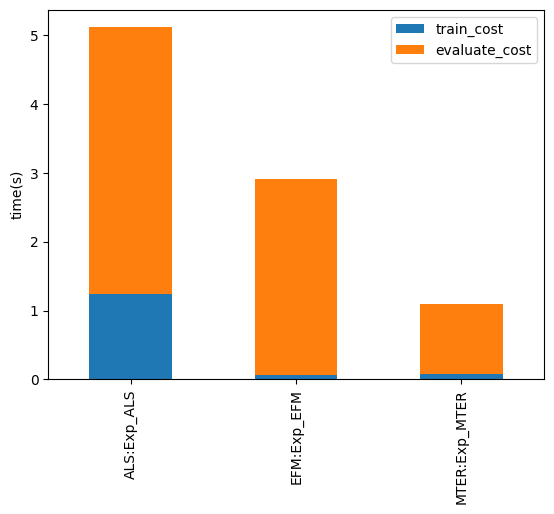

In [4]:
vis = Visualization()
vis.visualize_experiemnt_result([experiment, experiment_sent], kind="bar")

### CASE 2 Visualize the Effect of Parameters' Change (rec_k, feature_k)
Problem:
    - Explainaer_Experiment(models = [model_1, model_2], rec_k=10, feature_k = 10) fixed parameter for all models/explainers 
Solution:
    - Pass a list of Explainer_Experiment Object to func Visualization_Parameter_Change([EE_1, EE_2, EE_3], param_name = 'rec_k/feature_k')

##### 2.1 Metrics FDIV&FPR on the sentiment-related model & explainers vs feature_k

In [2]:
from cornac.experiment.experiment_explainers import Experiment_Explainers
from cornac.datasets.goodreads import prepare_data
from cornac.metrics_explainer import (
    Metric_Exp_DIV as DIV,
    Metric_Exp_FPR as FPR,
    Metric_Exp_FA as FA,
    Metric_Exp_RA as RA,
)
from cornac.models import EFM, MTER
from cornac.models import ALS, MF, EMF, NEMF

from cornac.explainer import Exp_EFM, Exp_MTER
from cornac.explainer import Exp_ALS, Exp_PHI4MF, Exp_SU4EMF

from cornac.experiment import Visualization
from cornac.utils import cache
import warnings

warnings.filterwarnings("ignore")

In [6]:
feature_k_list = [i for i in range(5, 11)]
rs_sent_dense = prepare_data(
    data_name="goodreads",
    test_size=0,
    dense=True,
    item=True,
    user=True,
    sample_size=1,
    seed=21,
)
fdiv = DIV()
fpr = FPR()
ground_truth_good_reads = goodreads.load_sentiment()
fpr_with_input_as_groundtruth = FPR(ground_truth=ground_truth_good_reads)
efm = EFM(
    max_iter=20,
    num_explicit_factors=50,
    num_latent_factors=50,
    num_most_cared_aspects=50,
    alpha=0.85,
    lambda_h=0.1,
    lambda_u=0.001,
    lambda_v=0.01,
    lambda_x=1.0,
    lambda_y=0.1,
)
efm_exp = Exp_EFM(rec_model=efm, dataset=rs_sent_dense.train_set)

mter = MTER(
    max_iter=20,
    n_aspect_factors=8,
    n_item_factors=5,
    n_opinion_factors=5,
    n_user_factors=10,
    lambda_bpr=10,
    lambda_reg=10,
    n_bpr_samples=1000,
    n_element_samples=50,
)
mter_exp = Exp_MTER(rec_model=mter, dataset=rs_sent_dense.train_set)

models = [(efm, efm_exp), (mter, mter_exp)]
metrics = [fdiv, fpr_with_input_as_groundtruth]

### To visualize the effect of increasing the number of features, we can run the experiment for different values of feature_k
EE_list = []
for feature_k in feature_k_list:
    experiment_sent = Experiment_Explainers(
        eval_method=rs_sent_dense,
        models=models,
        metrics=metrics,
        rec_k=10,
        feature_k=feature_k,
        eval_train=True,
    )
    experiment_sent.run()
    EE_list.append(experiment_sent)

INFO:cornac.experiment.experiment_explainers:Start training Recommender EFM...
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EFM creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_EFM create explanation for all recommendations
Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 8347.94it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.5531531531529946
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_FPR starts evaluation...
Start evaluation... :   0%|          | 0/9000 [00:00<?, ?it/s]
INFO:cornac.experiment.experiment_explainers:Result: Feature Precision: 0.3889541715628672; Feature Recall: 0.058709994930925845; Harmonic Mean: 0.09340723655307186
INFO:cornac.expe

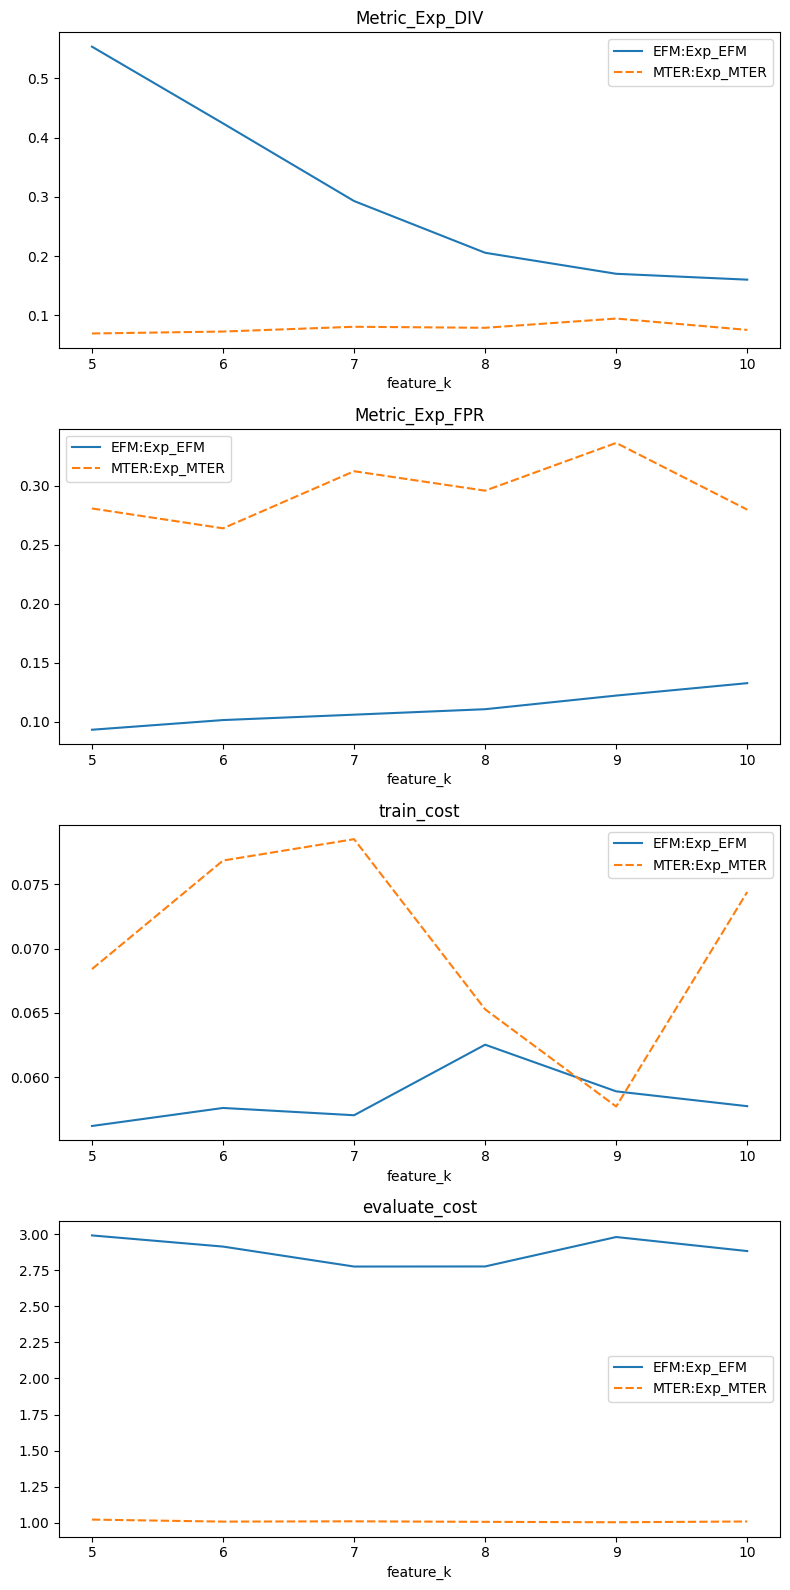

In [7]:
vis = Visualization()
vis.visualize_target_k(EE_list, target_k_name="feature_k", kind="line")

##### 2.1 Metrics FDIV on the MF models & explainers vs feature_k

In [1]:
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.experiment.experiment_explainers import Experiment_Explainers
from cornac.models import EMF, NEMF, ALS
from cornac.explainer import Exp_ALS, Exp_PHI4MF, Exp_SU4EMF
from cornac.metrics_explainer import (
    Metric_Exp_DIV as DIV,
    Metric_Exp_PGF as PGF,
    Metric_Exp_MEP as MEP,
    Metric_Exp_EnDCG as EnDCG,
)

# Load MovieLens
data = movielens.load_feedback(variant="100K")

# To speed up the experiment and limitation by memory, we only use a subset of the data
data = data[:5000]

# Define an evaluation method to split feedback into train and test sets
ratio_split = RatioSplit(
    data=data, test_size=0.2, exclude_unknowns=False, verbose=True
)

emf = EMF(
    k=10,
    max_iter=500,
    learning_rate=0.001,
    lambda_reg=0.1,
    explain_reg=0.01,
    verbose=True,
    seed=6,
    num_threads=6,
    early_stop=True,
)
nemf = NEMF(
    k=10,
    max_iter=500,
    learning_rate=0.001,
    lambda_reg=0.1,
    explain_reg=0.01,
    novel_reg=1,
    verbose=True,
    seed=6,
    num_threads=6,
    early_stop=True,
)
als = ALS(k=10, max_iter=500, lambda_reg=0.001, alpha=1, verbose=True, seed=6)
als_exp = Exp_ALS(rec_model=als, dataset=ratio_split.train_set)
emf_exp = Exp_PHI4MF(rec_model=emf, dataset=ratio_split.train_set)
nemf_exp = Exp_SU4EMF(rec_model=nemf, dataset=ratio_split.train_set)
fdiv = DIV()
models = [(als, als_exp), (emf, emf_exp), (nemf, nemf_exp)]
metrics = [fdiv]

# feature_k_list = [i for i in range(5, 11)]
rec_k_list = [i for i in range(5, 11)]
EE_list = []
for rec_k in rec_k_list:
    print(f"\nCurrent loop: Processing rec_k = {rec_k}")
    experiment = Experiment_Explainers(
        eval_method=ratio_split,
        models=models,
        metrics=metrics,
        rec_k=rec_k,
        feature_k=10,
        eval_train=True,
    )
    experiment.run()
    EE_list.append(experiment)

/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/tensorflow/python/debug/cli/debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...


rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 336
Number of items = 1014
Number of ratings = 4000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 338
Number of items = 1061
Number of ratings = 1000
Number of unknown users = 2
Number of unknown items = 47
---
Total users = 338
Total items = 1061

Current loop: Processing rec_k = 5


/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 6 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:implicit:Final training loss 0.0251
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations:   0%|          | 0/1690 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.013174404812566036
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_PHI4MF create explanation for all recommendations


Optimization finished!


Computing explanations:   0%|          | 0/1690 [00:00<?, ?it/s]

Association rules generated


INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.007986824868225736
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Optimization finished!


Computing explanations:   0%|          | 0/1690 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.30957425169250236
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.013174404812566036, 2.2980377674102783, 11.627567768096924], [0.007986824868225736, 0.5581648349761963, 340.19656920433044], [0.30957425169250236, 0.785700798034668, 3.4581339359283447]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |       Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.013174404812566036 | 2.2980377674102783 | 11.627567768096924
EMF:Exp_PHI4MF        | 0.007986824868225736 | 0.5581648349761963 | 340.19656920433044
NEMF:Exp_SU4EMF       |  0.30957425169250236 |  0.785700798034668 | 3.4581339359283447

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...



Current loop: Processing rec_k = 6


/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:implicit:Final training loss 0.0251
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations:   0%|          | 0/2028 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.01327019434737907
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF creates recommendations


Optimization finished!


INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_PHI4MF create explanation for all recommendations


Computing explanations:   0%|          | 0/2028 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.0083515461329721
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations


Optimization finished!


INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Computing explanations:   0%|          | 0/2028 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.2700939409758906
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.01327019434737907, 2.3472816944122314, 14.693105697631836], [0.0083515461329721, 0.5661325454711914, 178.87049078941345], [0.2700939409758906, 0.7490730285644531, 4.174637794494629]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |      Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.01327019434737907 | 2.3472816944122314 | 14.693105697631836
EMF:Exp_PHI4MF        |  0.0083515461329721 | 0.5661325454711914 | 178.87049078941345
NEMF:Exp_SU4EMF       |  0.2700939409758906 | 0.7490730285644531 |  4.174637794494629

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...



Current loop: Processing rec_k = 7


/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:implicit:Final training loss 0.0251
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations:   0%|          | 0/2366 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.013276853169996003
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF creates recommendations


Optimization finished!


INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_PHI4MF create explanation for all recommendations


Computing explanations:   0%|          | 0/2366 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.008909524864082698
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations


Optimization finished!


INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Computing explanations:   0%|          | 0/2366 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.2603118635989332
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.013276853169996003, 2.60025691986084, 20.586650133132935], [0.008909524864082698, 0.6927216053009033, 207.73204064369202], [0.2603118635989332, 0.8092131614685059, 5.253973007202148]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |       Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.013276853169996003 |   2.60025691986084 | 20.586650133132935
EMF:Exp_PHI4MF        | 0.008909524864082698 | 0.6927216053009033 | 207.73204064369202
NEMF:Exp_SU4EMF       |   0.2603118635989332 | 0.8092131614685059 |  5.253973007202148

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...



Current loop: Processing rec_k = 8


/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:implicit:Final training loss 0.0251
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations:   0%|          | 0/2704 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.013309136456914191
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_PHI4MF create explanation for all recommendations


Optimization finished!


Computing explanations:   0%|          | 0/2704 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.008928873977391378
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Optimization finished!


Computing explanations:   0%|          | 0/2704 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.2581654701200491
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.013309136456914191, 2.229787588119507, 21.615436553955078], [0.008928873977391378, 0.569105863571167, 236.53859496116638], [0.2581654701200491, 0.7634425163269043, 5.23184609413147]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |       Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.013309136456914191 |  2.229787588119507 | 21.615436553955078
EMF:Exp_PHI4MF        | 0.008928873977391378 |  0.569105863571167 | 236.53859496116638
NEMF:Exp_SU4EMF       |   0.2581654701200491 | 0.7634425163269043 |   5.23184609413147

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...



Current loop: Processing rec_k = 9


/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:implicit:Final training loss 0.0251
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations:   0%|          | 0/3042 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.013329083195306266
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_PHI4MF create explanation for all recommendations


Optimization finished!


Computing explanations:   0%|          | 0/3042 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.00903392121855613
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Optimization finished!


Computing explanations:   0%|          | 0/3042 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.2542464280096587
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.013329083195306266, 2.1581778526306152, 25.771656274795532], [0.00903392121855613, 0.5910778045654297, 257.39012813568115], [0.2542464280096587, 0.9860711097717285, 5.728515863418579]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |       Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.013329083195306266 | 2.1581778526306152 | 25.771656274795532
EMF:Exp_PHI4MF        |  0.00903392121855613 | 0.5910778045654297 | 257.39012813568115
NEMF:Exp_SU4EMF       |   0.2542464280096587 | 0.9860711097717285 |  5.728515863418579

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...



Current loop: Processing rec_k = 10


/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:implicit:Final training loss 0.0251
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations:   0%|          | 0/3380 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.013349160444098626
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_PHI4MF create explanation for all recommendations


Optimization finished!


Computing explanations:   0%|          | 0/3380 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.00936579062838355
INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...
/home/linan/miniconda3/envs/cornac/lib/python3.11/site-packages/cornac-2.0.0-py3.11-linux-x86_64.egg/cornac/models/recommender.py:307: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations


Optimization finished!


INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Computing explanations:   0%|          | 0/3380 [00:00<?, ?it/s]

INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.246218179801433
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.013349160444098626, 2.3929603099823, 28.659612894058228], [0.00936579062838355, 0.6500136852264404, 286.1181409358978], [0.246218179801433, 0.7306761741638184, 6.864865064620972]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |       Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.013349160444098626 |    2.3929603099823 | 28.659612894058228
EMF:Exp_PHI4MF        |  0.00936579062838355 | 0.6500136852264404 |  286.1181409358978
NEMF:Exp_SU4EMF       |    0.246218179801433 | 0.7306761741638184 |  6.864865064620972



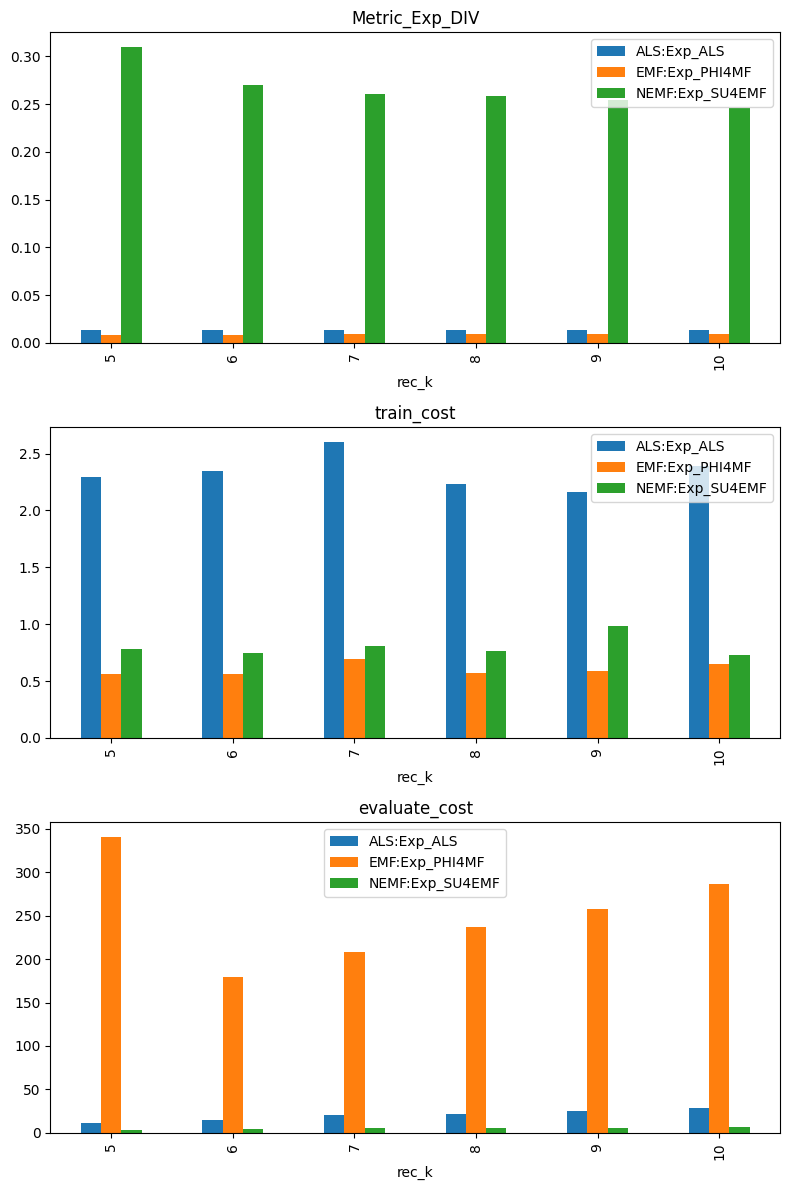

In [2]:
from cornac.experiment import Visualization

vis = Visualization()
vis.visualize_target_k(EE_list, target_k_name="rec_k", kind="bar")

### CASE 3 Visualize feature importance

The visualization function can be called for a specific user and item, or an item, or a user, or all users

In [1]:
import numpy as np
from cornac.models.fm_py import FMRec
from cornac.explainer.exp_limers import Exp_LIMERS
from cornac.datasets.goodreads import prepare_data
import warnings

warnings.filterwarnings("ignore")
from cornac.datasets import amazon_toy
import numpy as np
from cornac.data import FeatureModality
from cornac.eval_methods import RatioSplit


def create_item_features_from_aspects(at_sentiment):
    """Separate aspects and opinions from sentiment data and create item and user features from them."""
    items = {}
    users = {}
    for _, row in enumerate(at_sentiment):
        user, item, sentiments = row
        if user not in users:
            users[user] = []
        if item not in items:
            items[item] = []
        for sentiment in sentiments:
            if sentiment[0] not in items[item]:
                items[item].append(sentiment[0])  # aspect adds to item feature
            if sentiment[1] not in users[user]:
                users[user].append(sentiment[1])  # opinion adds to user feature

    item_aspect_pairs = np.array(
        [(item, feature) for item in items for feature in items[item]]
    )
    user_opinion_pairs = np.array(
        [(user, feature) for user in users for feature in users[user]]
    )
    return item_aspect_pairs, user_opinion_pairs, items.keys(), users.keys()


at_feedback = amazon_toy.load_feedback()
at_feedback = at_feedback[: len(at_feedback) // 20]  # reduce data size
at_sentiment = amazon_toy.load_sentiment()
items_feature, users_feature, items_list, users_list = (
    create_item_features_from_aspects(at_sentiment)
)
# remove unknown users and items from rating data
at_feedback_excl_unknowns = [
    x for x in at_feedback if x[0] in users_list and x[1] in items_list
]
rs = RatioSplit(
    data=at_feedback,
    test_size=0.2,
    item_feature=FeatureModality(items_feature),
    # user_feature=FeatureModality(users_feature), # user feature is not used in this experiment
    seed=42,
    exclude_unknowns=True,
)


fm = FMRec()
fm.fit(train_set=rs.train_set)

explainer = Exp_LIMERS(rec_model=fm, dataset=rs.train_set)
users = np.array(list(rs.train_set.uid_map.keys()))
items = np.array(list(rs.train_set.iid_map.keys()))
recommendations = fm.recommend_to_multiple_users(users, k=10)
explanations = explainer.explain_recommendations(recommendations, num_features=6)

/Users/yyz/miniconda3/envs/rose_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.84281
-- Epoch 2
Training MSE: 0.54980
-- Epoch 3
Training MSE: 0.47657
-- Epoch 4
Training MSE: 0.43989
-- Epoch 5
Training MSE: 0.40551
-- Epoch 6
Training MSE: 0.38343
-- Epoch 7
Training MSE: 0.37048
-- Epoch 8
Training MSE: 0.35304
-- Epoch 9
Training MSE: 0.33992
-- Epoch 10
Training MSE: 0.33300


Computing explanations: 100%|██████████| 46680/46680 [19:06<00:00, 40.72it/s]


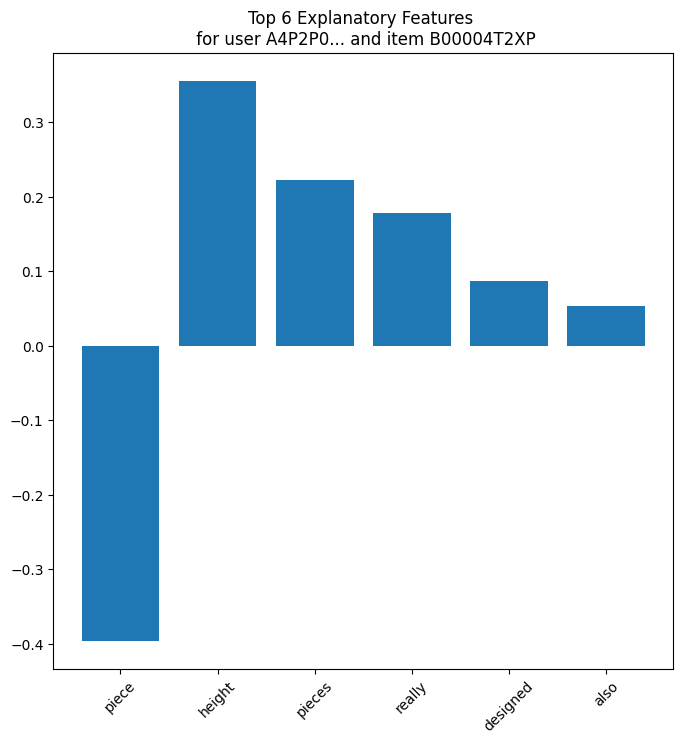

In [2]:
from cornac.experiment.visualization import Visualization

explanations_df = explanations.copy()
my_plots = Visualization()

# Create a plot for a specific user and item
ind_df = my_plots.create_individual_feature_importance_plot(
    explanations,
    user_id="A4P2P0GAMR7XX",
    item_id="B00004T2XP",
    type="bar",
    top_k=6,
    save_plot=False,
)

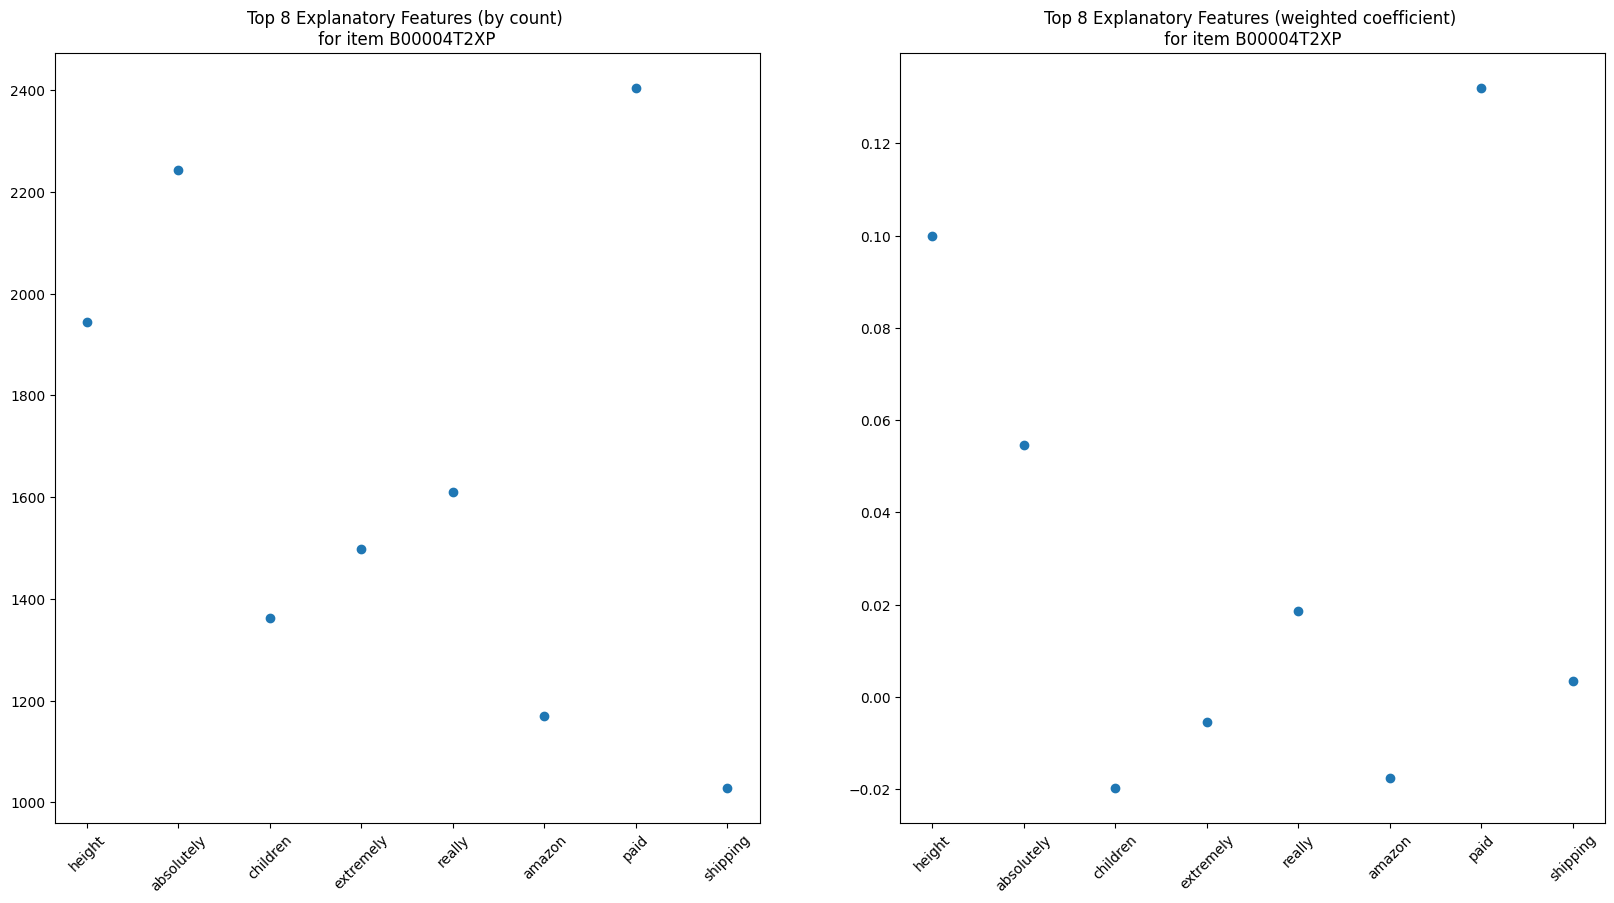

In [3]:
# Create a plot for a specific item
filtered_df1 = my_plots.create_aggregate_feature_importance_plot(
    explanations, item_id="B00004T2XP", type="scatter", top_k=8, save_plot=False
)

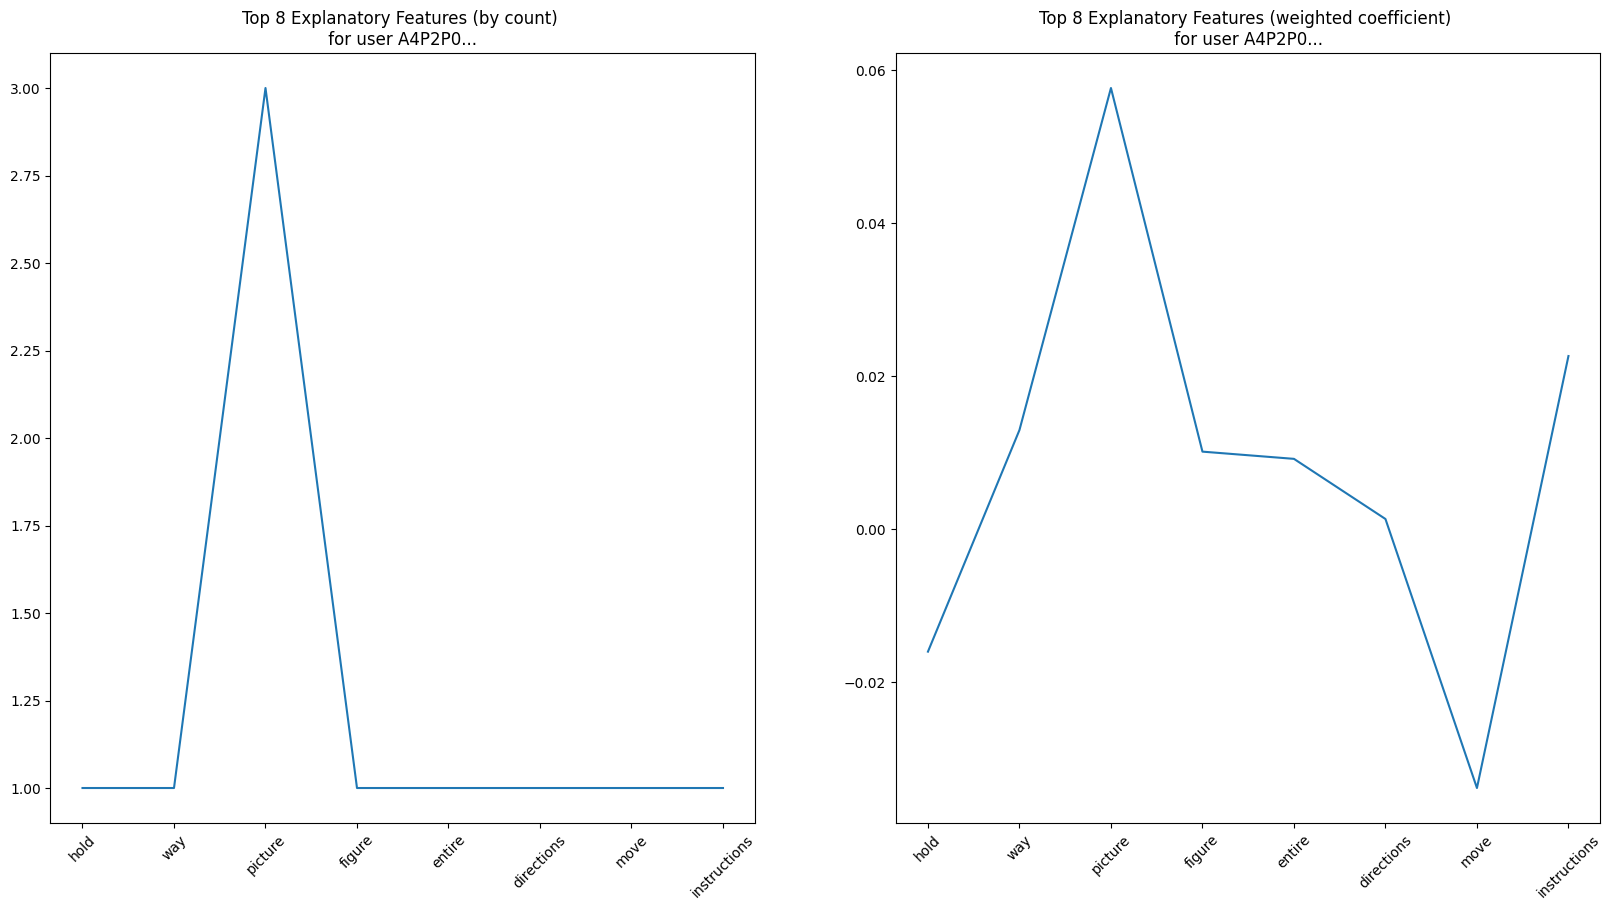

In [4]:
# Create a plot for a specific user
filtered_df2 = my_plots.create_aggregate_feature_importance_plot(
    explanations,
    user_id="A4P2P0GAMR7XX",
    type="line",
    top_k=8,
    save_plot=False,
)

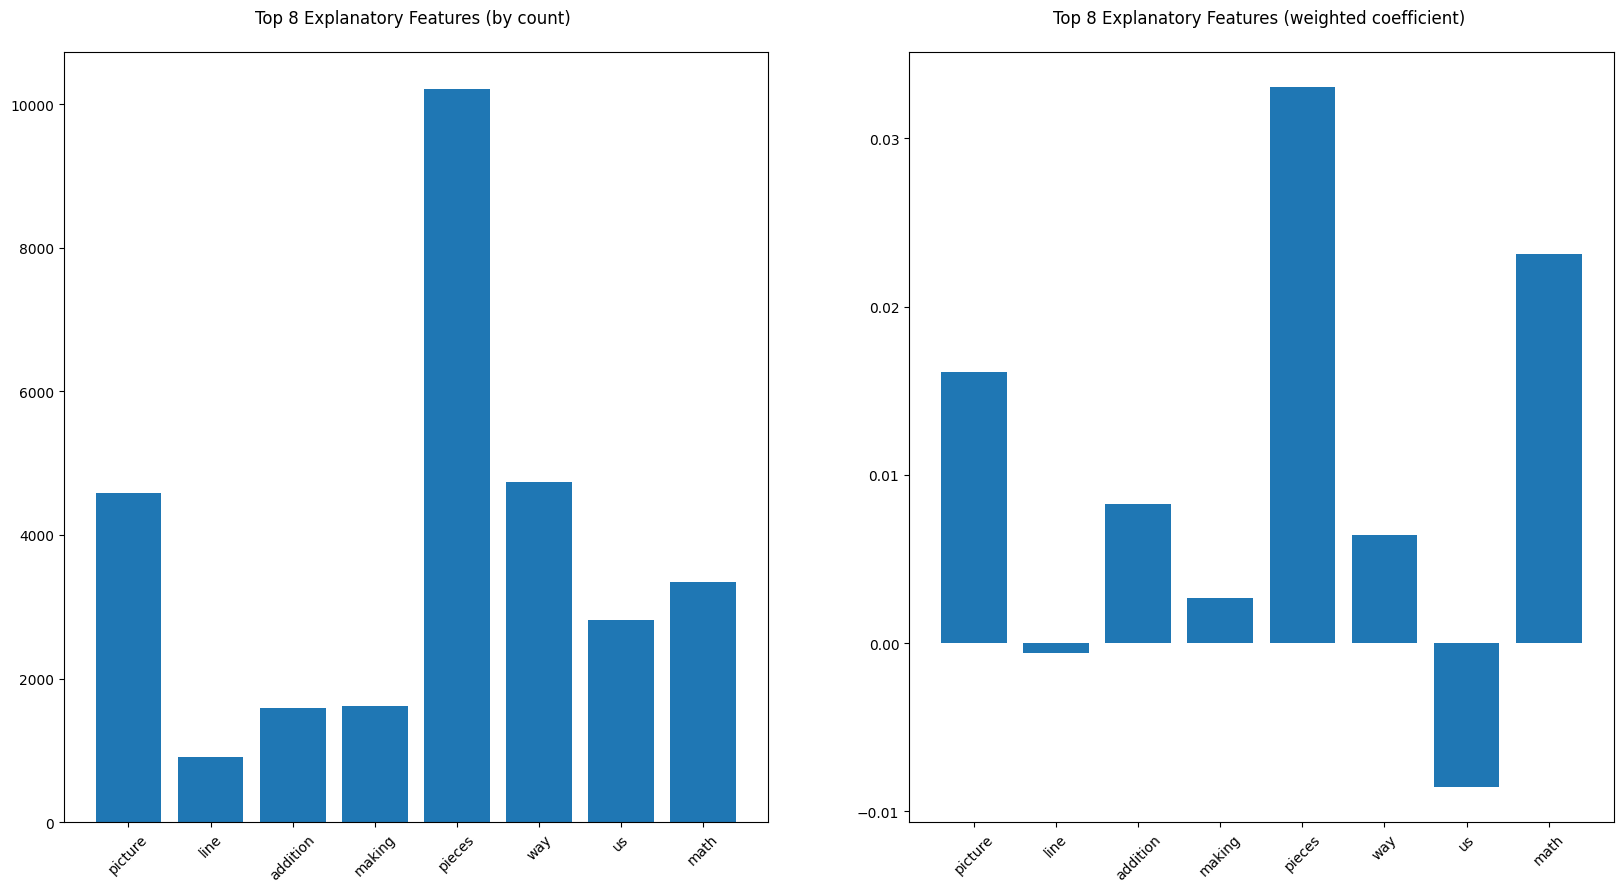

In [5]:
# Create a plot for all users
filtered_df3 = my_plots.create_aggregate_feature_importance_plot(
    explanations, type="bar", top_k=8, save_plot=False
)